In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

import md_lvm
importlib.reload(md_lvm)
import saem
importlib.reload(saem)

<module 'saem' from '/Users/francescacrucinio/Documents/MD_LVM/saem.py'>

In [2]:
nodes = 100
pi = np.array([0.6, 0.4])
probs = np.array([[0.25, 0.1], [0.1, 0.2]])

In [3]:
# def sbm_sample(pi, nu, nodes):
#     # block allocation
#     x = np.random.choice(np.arange(len(pi)), nodes, p=pi)
#     # adjacency matrix 
#     A = np.zeros((nodes, nodes))
#     for i in range(nodes):
#         A[i, np.delete(np.arange(nodes), i)] = np.random.binomial(1, p = probs[x[i], np.delete(x, i)], size = nodes-1)
#     return A, x

In [4]:
# y, res_z = sbm_sample(pi, probs, nodes)
# # y = np.loadtxt("adj.txt")

In [5]:
z = np.loadtxt("z.txt")
y = np.loadtxt("adj.txt")

In [6]:
th0 = np.array([0.3, 0.3, 0.3, 0.3, 0.3])  # Initial parameter guess.
X0 = np.random.binomial(1, 0.5, nodes)  # Initial particle cloud.

In [7]:
Niter = 500
Nrep = 50
N = nodes
gamma = 0.02
theta_saem_est = np.zeros((Nrep, 5))
runtime_saem = np.zeros(Nrep)
ari_saem = np.zeros(Nrep)
theta_md_est = np.zeros((Nrep, 5))
ari_md = np.zeros(Nrep)
runtime_md = np.zeros(Nrep)

In [8]:
for j in range(Nrep):
    start = time.time()
    # SAEM
    z_iter = np.zeros([Niter, nodes])
    s1_iter = np.zeros(Niter)
    s2_iter = np.zeros((Niter, 4))
    s3_iter = np.zeros((Niter, 4))
    theta_saem = np.zeros((Niter, th0.size))
    n = 0
    z_iter[n, :] =  np.random.binomial(1, 0.5, size = nodes)
    theta_saem[n,:] = th0
    for n in range(1, Niter):
        delta = 1/n
        z_iter[n, :] = saem.sbm_saem_proposal(y, z_iter[n-1, :], theta_saem[n-1,:])
        s1_update, s2_update, s3_update = saem.sbm_saem_sufficient_stat(z_iter[n, :], y)
        s1_iter[n] = s1_iter[n-1] + delta*(s1_update - s1_iter[n-1])
        s2_iter[n, :] = s2_iter[n-1, :] + delta*(s2_update - s2_iter[n-1, :])
        s3_iter[n, :] = s3_iter[n-1, :] + delta*(s3_update - s3_iter[n-1, :])
        theta_saem[n,:] = saem.sbm_saem_mle(s1_iter[n], s2_iter[n,:], s3_iter[n,:], nodes)
    ari_saem[j] = saem.sbm_ari(z-1, z_iter[-1,:])
    theta_saem_est[j, :] = theta_saem[-1,:]
    end = time.time()
    runtime_saem[j] = end-start
    # SMC-LVMs
    start = time.time()
    theta_md, x_md, W = md_lvm.md_sbm_fast(y, gamma, Niter, N, th0, X0)
    end = time.time()
    runtime_md[j] = end-start
    ari_md[j] = saem.sbm_ari(z-1, x_md[-1,:])
    theta_md_est[j, :] = theta_md[-1,:]
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
np.mean(ari_saem), np.mean(ari_md)

(0.5141737373737373, 0.8249535353535353)

In [72]:
np.mean(runtime_md)/np.mean(runtime_saem)

2.6061143219437906

In [78]:
np.mean(np.mean(se_saem, axis = 0)/np.mean(se_md, axis = 0))

92.10110195135935

In [28]:
rse_saem = np.zeros((Nrep, 5))
se_saem = np.zeros((Nrep, 5))
switched_saem = np.zeros((Nrep))
rse_md = np.zeros((Nrep, 5))
se_md = np.zeros((Nrep, 5))
switched_md = np.zeros((Nrep))
for j in range(Nrep):
    se_saem[j, :], rse_saem[j, :], switched_saem[j] = saem.se_sbm(theta_saem_est[j], pi, probs)
    se_md[j, :], rse_md[j, :], switched_md[j] = saem.se_sbm(theta_md_est[j], pi, probs)

In [67]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

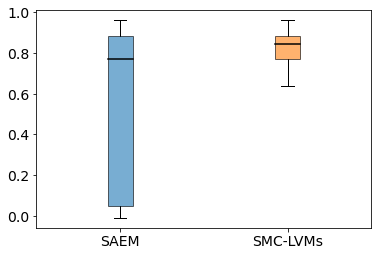

In [68]:
boxp = plt.boxplot([ari_saem, ari_md], labels = ["SAEM", "SMCs-LVM"], whis = 15, patch_artist=True);
for patch, color in zip(boxp['boxes'], colors):
    patch.set_alpha(0.6)
    patch.set_facecolor(color)
for median in boxp['medians']:
    median.set(color='k', linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
# plt.yscale('log')
# plt.savefig('sbm_ari.pdf', bbox_inches="tight")

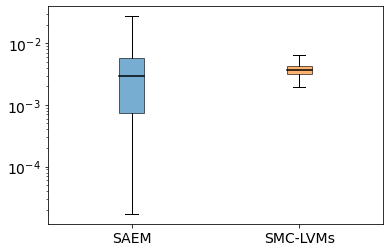

In [48]:
i = 0
boxp = plt.boxplot([se_saem[:, i], se_md[:, i]], whis = 15, patch_artist=True, labels = ["SAEM", "SMCs-LVM"]);
for patch, color in zip(boxp['boxes'], colors):
    patch.set_alpha(0.6)
    patch.set_facecolor(color)
for median in boxp['medians']:
    median.set(color='k', linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.yscale('log')

In [69]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = np.repeat(prop_cycle.by_key()['color'][:2], 5)
colors 

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e'], dtype='<U7')

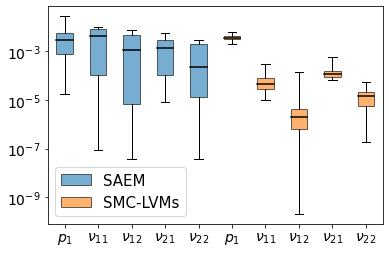

In [71]:
boxp = plt.boxplot(np.concatenate((se_saem, se_md), axis = 1), whis = 50, patch_artist=True, labels = [f"${{p_{{1}}}}$",f"${{\\nu_{{11}}}}$", f"${{\\nu_{{12}}}}$", f"${{\\nu_{{21}}}}$", 
                                                                                f"${{\\nu_{{22}}}}$", f"${{p_{{1}}}}$", f"${{\\nu_{{11}}}}$", f"${{\\nu_{{12}}}}$", f"${{\\nu_{{21}}}}$", 
                                                                                f"${{\\nu_{{22}}}}$"]);
plt.yscale('log')
for patch, color in zip(boxp['boxes'], colors):
    patch.set_alpha(0.6)
    patch.set_facecolor(color)
for median in boxp['medians']:
    median.set(color='k', linewidth=1.5)
plt.legend([boxp["boxes"][0], boxp["boxes"][5]], ["SAEM", "SMCs-LVM"], fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
# plt.savefig('sbm_mse.pdf', bbox_inches="tight")

In [19]:
np.sum(switched_saem)/Nrep, np.sum(switched_md)/Nrep

(0.8, 0.1)

In [22]:
theta_saem_est_tmp = np.matrix(theta_saem_est)
with open('sbm_saem.txt','wb') as f:
    for line in theta_saem_est_tmp:
        np.savetxt(f, line)

In [23]:
theta_md_est_tmp = np.matrix(theta_md_est)
with open('sbm_md.txt','wb') as f:
    for line in theta_md_est_tmp:
        np.savetxt(f, line)

In [25]:
parameters = np.matrix([ari_md, runtime_md])
with open('sbm_md_ari_time.txt','wb') as f:
    for line in parameters:
        np.savetxt(f, line)

In [26]:
parameters = np.matrix([ari_saem, runtime_saem])
with open('sbm_saem_ari_time.txt','wb') as f:
    for line in parameters:
        np.savetxt(f, line)